In [24]:
import librosa
import numpy as np
import pandas as pd
from datetime import timedelta
import glob
import natsort
import pandas as pd
import numpy as np
import math
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

# from tensorflow.keras import optimizers
# from keras.callbacks import ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D,BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, ZeroPadding2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from datetime import timedelta

from keras.callbacks import ModelCheckpoint
# from tensorflow.keras import optimizers
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [25]:
def visualize(path: str):
    
    # reading the audio file
    raw = wave.open(path)
    Audio(path)  
    # reads all the frames 
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
      
    # gets the frame rate
    f_rate = raw.getframerate()
  
    # to Plot the x-axis in seconds 
    # you need get the frame rate 
    # and divide by size of your signal
    # to create a Time Vector 
    # spaced linearly with the size 
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
      
    )
    Audio(path)
   
  
    # using matlplotlib to plot
    # creates a new figure
    plt.figure(1)
      
    # title of the plot
    plt.title(path.split('_')[2])
      
    # label of x-axis
    plt.xlabel("Time")
     
    # actual ploting
    plt.plot(time, signal)
      
    # shows the plot 
    # in new window
    plt.show()
  
    # you can also save
    # the plot using
    # plt.savefig('filename')
  

In [26]:
def createFileList(format='.wav'):
    fileList = []
    #print(/content/Crema)
    for root, dirs, files in os.walk('/Users/omarkhaled/Documents/pr/Crema', topdown=False):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
    return fileList



In [27]:
fileList = createFileList()
Emotions=['HAP','DIS','FEA','NEU','SAD','ANG']
Emotions=np.array(Emotions)
#print(fileList[0].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+Emotions[0]+'_'+'XX.wav')
for feel in Emotions:
  path=fileList[1500].split('_')[0]+'_'+fileList[0].split('_')[1]+'_'+feel+'_'+'XX.wav'
  #path='1001'+'_'+'DFA'+'_'+feel+'_'+'XX.wav'

  # visualize(path)
 
 
 

In [ ]:
audio = tfio.audio.AudioIOTensor(fileList[0])
audio=audio.to_tensor()
tensor = tf.cast(audio, tf.float32) / 32768.0
print(audio.shape)



(47514, 1)


In [28]:
onehot_encoded_data=[]
for i in fileList:
  onehot_encoded_data.append([i.split('_')[2]])
emotion_df = pd.DataFrame( onehot_encoded_data , columns=['Emotions'] )

# dataframe for path of files.
path_df = pd.DataFrame(fileList, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


onehot_encoded_data=np.array(onehot_encoded_data)
encoder = OneHotEncoder(sparse=False)
onehot_encoded_data = encoder.fit_transform(onehot_encoded_data)




,Emotions,Path
0,ANG,/Users/omarkhaled/Documents/pr/Crema/1022_ITS_...
1,ANG,/Users/omarkhaled/Documents/pr/Crema/1037_ITS_...
2,NEU,/Users/omarkhaled/Documents/pr/Crema/1060_ITS_...
3,NEU,/Users/omarkhaled/Documents/pr/Crema/1075_ITS_...
4,DIS,/Users/omarkhaled/Documents/pr/Crema/1073_IOM_...
5,DIS,/Users/omarkhaled/Documents/pr/Crema/1066_IOM_...


In [29]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


    

In [30]:
def shortTermEnergy(frame):
  return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [31]:
def zeroCrossingRate(frame):
  signs             = numpy.sign(frame)
  signs[signs == 0] = -1

  return len(numpy.where(numpy.diff(signs))[0])/len(frame)

In [70]:
def extract_features(data,sample_rate):
    #data, sample_rate = librosa.load(fileList)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # # Chroma_stft
    # stft = np.abs(librosa.stft(data))
    # chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, chroma_stft)) # stacking horizontally

    # # MFCC
    # mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    # result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally
    
    #short term energy
    result= shortTermEnergy((result,shortTermEnergy(data)))
    
    # #spectral centroid
    # cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis = 0)
    # result = np.hstack((result, cent))
    
    # #spectral bandwidth
    # spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T,axis = 0)
    # result = np.hstack((result, spec_bw))


    # #spectral flattness
    # flatness = np.mean(librosa.feature.spectral_flatness(y=data).T,axis=0)
    # result = np.hstack((result, flatness))

    return result


In [34]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)



In [35]:
def get_features(path, augment):
    # duration and offset are used to take care of the no audivvo in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path)#, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
 
    result = np.array(res1)
    
    if augment:
        # data with noise
        noise_data = noise(data)
        
        res2 = extract_features(noise_data,sample_rate)
        
        result = np.vstack((result, res2)) # stacking vertically
        
        # data with stretching and pitching
        new_data = stretch(data)
        
        data_stretch_pitch = pitch(new_data, sample_rate)
        
        res3 = extract_features(data_stretch_pitch,sample_rate)
        
        result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [36]:
##function generate mel spectogram for read audio 
def get_mel_wav(data,sr):
  mel_spectrogram = librosa.feature.melspectrogram(data, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [71]:
##splitting thDS to test,train,val and specifing batch_size,epochs,num_classes
X1_train, X1_test, y1_train, y1_test = train_test_split( fileList, onehot_encoded_data, test_size=0.2, random_state=42,shuffle='Yes')
X1_trainfinal, X1_vaildate, y1_trainfinal, y1_validate = train_test_split( X1_train, y1_train, test_size=0.1, random_state=42,shuffle='Yes')

batch_size = 128
epochs = 50
num_classes = 6


In [72]:
X_train = X1_trainfinal
y_train = y1_trainfinal

In [73]:
X, Y = [], []
X_train=np.array(X_train)
i =0
runs =100
for path, emotion in zip(X_train,y_train):
    if i%runs == 0:
        print(i)
    feature = get_features(path,True)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    i+=1

0


In [40]:
X_train_features = np.array(X)
y_train_features = np.array(Y)
# new_ytrain = np.copy(y_train_features)
# new_ytrain = np.repeat(new_ytrain, 3, axis=0)
# y_train_features = new_ytrain
# test = np.copy(X_train_features)
# # print(test[0])
# test = test.reshape(((test.shape[0]*test.shape[1]),test.shape[2]))
# X_train_features = test
print(X_train_features.shape,y_train_features.shape)

(16071, 37) (16071, 6)


In [41]:
X_test = X1_test
y_test = y1_test
X_validate = X1_vaildate
y_validate = y1_validate

In [42]:
X2, Y2 = [], []
X_test=np.array(X_test)
for path, emotion in zip(X_test,y_test):
    feature = get_features(path,False)
    X2.append(feature)
    Y2.append(emotion)

In [43]:
X3, Y3 = [], []
X_validate=np.array(X_validate)

for path, emotion in zip(X_validate,y_validate):
    feature = get_features(path,False)
    X3.append(feature)
    Y3.append(emotion)
        
   

In [44]:
X_test_features = np.array(X2)
y_test_features = np.array(Y2)
X_validate_features = np.array(X3)
y_validate_features = np.array(Y3)

In [45]:
X_train_features = X_train_features[:,:,np.newaxis]
# y_train_features = y_train_features[:,:,np.newaxis]
X_test_features  = X_test_features[:,:,np.newaxis]
# y_test_features = y_test_features[:,:,np.newaxis]
X_validate_features = X_validate_features[:,:,np.newaxis]
# y_validate_features = y_validate_features[:,:,np.newaxis]


In [47]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)
# print(y_train_features[0])

(16071, 37, 1) (16071, 6) (1489, 37, 1) (1489, 6) (596, 37, 1) (596, 6)


In [48]:
with open('features_80(90-10)_20.npy', 'wb') as f:
    np.save(f, X_train_features)
    np.save(f, y_train_features)

    np.save(f, X_test_features)
    np.save(f, y_test_features)

    np.save(f, X_validate_features)
    np.save(f, y_validate_features)


In [2]:
#reading the data set feom the npy file
import numpy as np
X_train_features = None
y_train_features = None
X_test_features =None
y_test_features = None
X_validate_features = None
y_validate_features = None

with open('features.npy', 'rb') as f:
    X_train_features = np.load(f)
    y_train_features = np.load(f)
    X_test_features = np.load(f)
    y_test_features = np.load(f)
    X_validate_features = np.load(f)
    y_validate_features = np.load(f)


In [49]:
print(X_train_features.shape,y_train_features.shape,X_test_features.shape,y_test_features.shape,X_validate_features.shape,y_validate_features.shape)

(16071, 37, 1) (16071, 6) (1489, 37, 1) (1489, 6) (596, 37, 1) (596, 6)


In [68]:
model=Sequential()


# model.add(Dense(units=512,activation='relu', input_shape=(X_train_features.shape[1], 1),use_bias= True))
# model.add(Dropout(0.2))

# model.add(Dense(units=64,activation='relu' ))
# model.add(Dropout(0.1))

# model.add(Dense(units=512,activation='relu'))
# model.add(Dropout(0.1))

model.add(Conv1D(512, kernel_size=7, strides=1, padding='same', activation='relu', input_shape=(X_train_features.shape[1], 1),use_bias= True))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=2, padding='same', activation='relu',use_bias= True))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu',use_bias= True))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())


# model.add(Conv1D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# # model.add(BatchNormalization())
# model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
# model.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(128, kernel_size=3, strides=3, padding='same', activation='relu'))
# # model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())

# model.add(Conv1D(256, kernel_size=3, strides=2, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(BatchNormalization())
model.add(Flatten())
# model.add(Dense(units=512,activation='relu'))

# model.add(Dropout(0.2))

model.add(Dense(units=256, activation='relu',use_bias= True))
# model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
# opt = optimizers.Adam(lr=0.001)
opt = optimizers.Adam(
  lr = 0.0001
)

model.compile(optimizer=opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_138 (Conv1D)          (None, 37, 512)           4096      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 10, 512)           1311232   
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 5, 512)            0         
_________________________________________________________________
conv1d_140 (Conv1D)          (None, 3, 128)            196736    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 1, 64)           

In [69]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=2, patience=5, min_lr=0.00000001,delta = 0.09)
# initial_learning_rate = 0.01
# def lr_step_decay(epoch, lr):
#     drop_rate = 0.1
#     epochs_drop = 10.0
#     return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))
# # Fit the model to the training data
# history_step_decay = 
# def step_decay(epoch):
# 	initial_lrate = initial_learning_rate
# 	drop = 0.5
# 	epochs_drop = 10.0
# 	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
# 	return lrate

# history = model.fit(
#     X1_train,
#     y1_train,
#     epochs=epochs,
#     validation_split=0.05,
#     batch_size=batch_size,
#     callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)],
# )

history=model.fit(X_train_features, y_train_features, batch_size=128, epochs=300, validation_data=(X_validate_features, y_validate_features),callbacks=[rlrp])
# , callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)],)
# , callbacks=[LearningRateScheduler(lr_step_decay, verbose=2)])
# , callbacks=[rlrp])

Epoch 1/300


2021-07-12 18:00:50.621691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 6s 47ms/step - loss: 1.7735 - accuracy: 0.1922 - val_loss: 1.7701 - val_accuracy: 0.1829
Epoch 2/300
  1/126 [..............................] - ETA: 5s - loss: 1.7770 - accuracy: 0.1875

2021-07-12 18:00:56.556445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 6s 47ms/step - loss: 1.7519 - accuracy: 0.2187 - val_loss: 1.7615 - val_accuracy: 0.1879
Epoch 3/300
126/126 [==============================] - 6s 46ms/step - loss: 1.7248 - accuracy: 0.2304 - val_loss: 1.7743 - val_accuracy: 0.2131
Epoch 4/300
126/126 [==============================] - 6s 46ms/step - loss: 1.7094 - accuracy: 0.2544 - val_loss: 1.7392 - val_accuracy: 0.2953
Epoch 5/300
126/126 [==============================] - 6s 46ms/step - loss: 1.6992 - accuracy: 0.2646 - val_loss: 1.7184 - val_accuracy: 0.2450
Epoch 6/300
126/126 [==============================] - 6s 46ms/step - loss: 1.6682 - accuracy: 0.2816 - val_loss: 1.6541 - val_accuracy: 0.2685
Epoch 7/300
126/126 [==============================] - 6s 46ms/step - loss: 1.6398 - accuracy: 0.2968 - val_loss: 1.6341 - val_accuracy: 0.2903
Epoch 8/300
126/126 [==============================] - 6s 46ms/step - loss: 1.6321 - accuracy: 0.2992 - val_loss: 1.6567 - val_accuracy: 0.2970
Epoc

KeyboardInterrupt: 

In [61]:

history=model.fit(X_train_features, y_train_features, batch_size=32, epochs=300, validation_data=(X_validate_features, y_validate_features))

Epoch 1/300
503/503 [==============================] - 10s 20ms/step - loss: 1.5072 - accuracy: 0.3620 - val_loss: 1.5592 - val_accuracy: 0.3540
Epoch 2/300
503/503 [==============================] - 10s 20ms/step - loss: 1.4906 - accuracy: 0.3681 - val_loss: 1.5459 - val_accuracy: 0.3574
Epoch 3/300
503/503 [==============================] - 10s 20ms/step - loss: 1.4876 - accuracy: 0.3710 - val_loss: 1.5730 - val_accuracy: 0.3473
Epoch 4/300
503/503 [==============================] - 10s 19ms/step - loss: 1.4793 - accuracy: 0.3772 - val_loss: 1.5215 - val_accuracy: 0.3574
Epoch 5/300
503/503 [==============================] - 10s 20ms/step - loss: 1.4892 - accuracy: 0.3720 - val_loss: 1.5214 - val_accuracy: 0.3591
Epoch 6/300
503/503 [==============================] - 10s 19ms/step - loss: 1.4816 - accuracy: 0.3730 - val_loss: 1.5852 - val_accuracy: 0.3557
Epoch 7/300
503/503 [==============================] - 10s 19ms/step - loss: 1.4788 - accuracy: 0.3775 - val_loss: 1.5097 - val_ac

KeyboardInterrupt: 

In [66]:
test_eval = model.evaluate(X_test_features, y_test_features, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.3937721252441406
Test accuracy: 0.43384823203086853


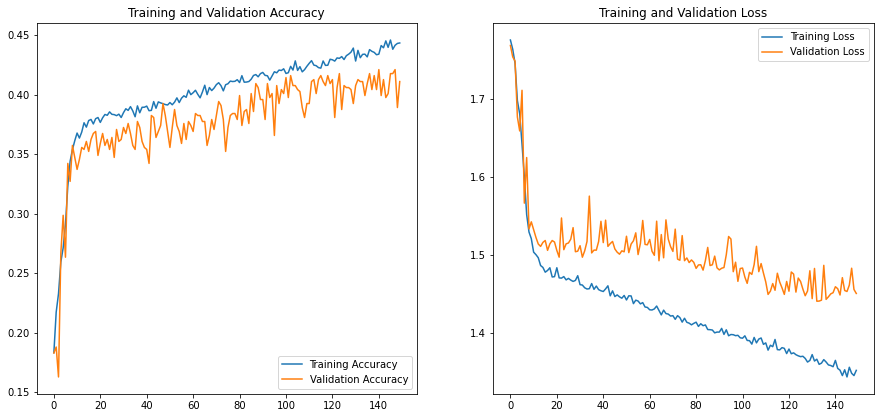

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(150)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()